# Example for using light module

In this notebook, we will show how to train and evaluate a network in 5 minutes with friendly log information to both screen and local file.

Before we use the light module, we need to
1. prepare the training dataset
2. define network
3. define the parameters we are going to use in a configuration, such as the model_dir to store the training log and the hyper parameters of network.
4. define how the model will be trained including:
    * the loss function
    * the fit procedure.
    * the trainer (trainer in mxnet, optim in pytorch)
5. we can additionally specify
    * initialization method
    * the evaluation including the data iterator and evaluation procedure
    * hyper parameters searching with nni
    * log to tensorboard
    * command line interface

For convenience, we call the five stages mentioned above as:
1. data preparation
2. network definition
3. configuration
4. training
5. additional

Furthermore, due to the implementation of these four parts are different in different frameworks,
with loss of generality, we only show the examples of mxnet and pytorch. This notebook is a demo of mxnet,
and the pytorch version can be found in [here](light_module_torch.ipynb)

Ok, let us start.

## Problem Statement and Data Preparation
We start from a classic learning problem `recognizing hand-written digits` and use sklearn to get dataset,
where the description of problem and dataset could be found in [here](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py).

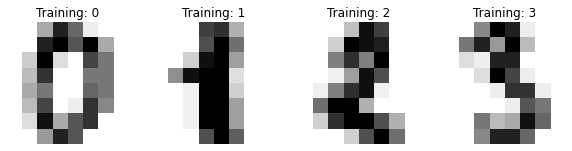

In [1]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pyplot as plt

digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [2]:
from sklearn.model_selection import train_test_split

# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# split dataset into train, validation and test
# we set (train, validation): test = 8 : 2 and train : validation = 9 : 1
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.2, shuffle=False)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False)

X_train, y_train

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  4., 14., ..., 11.,  0.,  0.],
        [ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0., 12., ...,  8.,  0.,  0.]]),
 array([0, 1, 2, ..., 3, 4, 5]))

In [3]:
# transform data to mxnet compatible format
from mxnet.gluon.data import ArrayDataset, DataLoader
def transform(x, y, batch_size, **params):
    dataset = ArrayDataset(x.astype("float32"), y.astype("float32"))
    return DataLoader(dataset, batch_size=batch_size, **params)

# because the batch_size and some other batch-relevant parameters are
# supposed to be determined in configuration,
# we will perform the real data transformation after we set the configuration.

## Network Definition

In [4]:
from mxnet import gluon

class MLP(gluon.HybridBlock):
    def __init__(self, hidden_layers=None, out=10, **kwargs):
        super(MLP, self).__init__(**kwargs)
        with self.name_scope():
            self.nn = gluon.nn.HybridSequential()
            if hidden_layers is not None:
                for hidden_unit in hidden_layers:
                    self.nn.add(
                        gluon.nn.Dense(hidden_unit, activation="tanh"),
                        gluon.nn.Dropout(0.5)
                    )
            self.nn.add(
                gluon.nn.Dense(out)
            )
    def hybrid_forward(self, F, x, *args, **kwargs):
        return F.log_softmax(self.nn(x))

## Configuration

In [5]:
from longling.ML.MxnetHelper.utils import Configuration

configuration = Configuration(model_name="mlp", model_dir="mlp")
configuration.end_epoch = 2
configuration.batch_size = 32
configuration.hyper_params = {"hidden_layers": [512, 128]}

configuration

logger: <Logger mlp (INFO)>
model_name: mlp
model_dir: mlp
begin_epoch: 0
end_epoch: 2
batch_size: 32
save_epoch: 1
optimizer: Adam
optimizer_params: {'learning_rate': 0.001, 'wd': 0.0001, 'clip_gradient': 1}
lr_params: {}
train_select: None
save_select: None
ctx: cpu(0)
toolbox_params: {}
hyper_params: {'hidden_layers': [512, 128]}
init_params: {}
loss_params: {}
caption: 
validation_result_file: mlp\result.json
cfg_path: mlp\configuration.json

## Training

In [6]:
import mxnet as mx
from mxnet import autograd

### Loss function

In [7]:
loss_f = gluon.loss.SoftmaxCELoss(from_logits=True)
loss_f

SoftmaxCrossEntropyLoss(batch_axis=0, w=None)

### Training Procedure

In [8]:
def fit_f(_net, batch_size, batch_data, trainer, loss_function, ctx=mx.cpu(), *args, **kwargs):
    with autograd.record():
        x, y = batch_data
        x = x.as_in_context(ctx)
        y = y.as_in_context(ctx)
        out = _net(x)
        loss = loss_function(out, y)
        loss.backward()
    trainer.step(batch_size)
    return loss


## Light Module

In [9]:
# Firstly transform (or say, batchify) the data into batches
train_data = transform(X_train, y_train, configuration.batch_size)
train_data

In [10]:
# Then set the network and initialize it
from longling.ML.MxnetHelper import light_module as lm

net = MLP(**configuration.hyper_params)
net.initialize(**configuration.init_params)

net

MLP(
  (nn): HybridSequential(
    (0): Dense(None -> 512, Activation(tanh))
    (1): Dropout(p = 0.5, axes=())
    (2): Dense(None -> 128, Activation(tanh))
    (3): Dropout(p = 0.5, axes=())
    (4): Dense(None -> 10, linear)
  )
)

In [11]:
# Define the trainer (also known as optimizer)
trainer = gluon.Trainer(net.collect_params(), "adam", {"learning_rate": 0.001})
trainer

After defining the necessary components needed in the training stage,
we spend a little time reviewing the classical training procedure in mxnet:

In [12]:
# An example in classic mxnet training style
import numpy as np
from tqdm import tqdm
for i in range(configuration.begin_epoch, configuration.end_epoch):
    losses = []
    for j, batch in tqdm(enumerate(train_data)):
        loss_v = fit_f(
            _net=net,
            batch_size=configuration.batch_size,
            batch_data=batch,
            trainer=trainer,
            loss_function=loss_f,
            ctx=configuration.ctx,
        )
        losses.append(loss_v.mean().asscalar())
    print("[Epoch %d]SoftmaxCELoss: %s" % (i, np.mean(losses)))

41it [00:00, 342.58it/s]
41it [00:00, 419.49it/s]


[Epoch 0]SoftmaxCELoss: 1.393923
[Epoch 1]SoftmaxCELoss: 0.5191189


In [13]:
# With light module, we can compress the training code into one line
# with more abundant assistant functions
# (e.g., better console output during training and the smooth calculation of loss values) which will run implicitly.
lm.train(
    net=net,
    loss_function=loss_f,
    cfg=configuration,
    trainer=trainer,
    train_data=train_data,
    fit_f=fit_f,
    initial_net=False
)

Epoch| Total-E          Batch     Total-B       Loss-SoftmaxCrossEntropyLoss             Progress           
    0|       1             41          41                            0.26979    [00:00<00:00, 224.64it/s]   
Epoch| Total-E          Batch     Total-B       Loss-SoftmaxCrossEntropyLoss             Progress           
    1|       1             41          41                           0.178796    [00:00<00:00, 215.23it/s]   


### Evaluation
Then let us try to attach some evaluation procedure during training on the validation dataset:

In [14]:
from longling.ML.metrics import classification_report
def eval_f(_net, test_data, ctx=mx.cpu()):
    y_true = []
    y_pred = []
    for x, y in test_data:
        x = x.as_in_context(ctx)
        pred = _net(x).argmax(-1).asnumpy().tolist()
        y_pred.extend(pred)
        y_true.extend(y.asnumpy().tolist())

    return classification_report(y_true, y_pred)

In [15]:
valid_data = transform(X_valid, y_valid, configuration.batch_size)
valid_data

In [16]:
net = MLP(**configuration.hyper_params)
net.initialize(**configuration.init_params)

trainer = gluon.Trainer(net.collect_params(), "adam", {"learning_rate": 0.001})

lm.train(
    net=net,
    loss_function=loss_f,
    cfg=configuration,
    trainer=trainer,
    train_data=train_data,
    test_data=valid_data,
    fit_f=fit_f,
    eval_f=eval_f,
    initial_net=False
)

Epoch| Total-E          Batch     Total-B       Loss-SoftmaxCrossEntropyLoss             Progress           
    0|       1             41          41                           0.985095    [00:00<00:00, 221.02it/s]   
Epoch [0]	Loss - SoftmaxCrossEntropyLoss: 0.985095
           precision    recall        f1  support
0.0         0.833333  1.000000  0.909091       15
1.0         0.764706  0.866667  0.812500       15
2.0         1.000000  0.571429  0.727273       14
3.0         0.875000  1.000000  0.933333       14
4.0         0.933333  1.000000  0.965517       14
5.0         1.000000  0.857143  0.923077       14
6.0         0.937500  1.000000  0.967742       15
7.0         1.000000  1.000000  1.000000       15
8.0         1.000000  0.714286  0.833333       14
9.0         0.764706  0.928571  0.838710       14
macro_avg   0.910858  0.893810  0.891058      144
accuracy: 0.895833
Epoch| Total-E          Batch     Total-B       Loss-SoftmaxCrossEntropyLoss             Progress           
   

You may want to use tqdm to show the progress:

In [17]:
lm.train(
    net=net,
    loss_function=loss_f,
    cfg=configuration,
    trainer=trainer,
    train_data=train_data,
    test_data=valid_data,
    fit_f=fit_f,
    eval_f=eval_f,
    progress_monitor="tqdm",
    initial_net=False
)

Epoch: 1: 100%|██████████| 41/41 [00:00<00:00, 419.49it/s]


Epoch [0]	Loss - SoftmaxCrossEntropyLoss: 0.25177
           precision    recall        f1  support
0.0         0.833333  1.000000  0.909091       15
1.0         0.937500  1.000000  0.967742       15
2.0         1.000000  0.785714  0.880000       14
3.0         1.000000  1.000000  1.000000       14
4.0         1.000000  1.000000  1.000000       14
5.0         1.000000  0.928571  0.962963       14
6.0         0.937500  1.000000  0.967742       15
7.0         1.000000  1.000000  1.000000       15
8.0         1.000000  1.000000  1.000000       14
9.0         1.000000  0.928571  0.962963       14
macro_avg   0.970833  0.964286  0.965050      144
accuracy: 0.965278
Epoch [1]	Loss - SoftmaxCrossEntropyLoss: 0.219581
           precision    recall        f1  support
0.0         0.882353  1.000000  0.937500       15
1.0         0.937500  1.000000  0.967742       15
2.0         1.000000  0.928571  0.962963       14
3.0         1.000000  1.000000  1.000000       14
4.0         1.000000  0.928571

## Simplest

With some toolkit functions, we can furthermore make the code simpler.

In [18]:
from longling.ML.MxnetHelper import fit_wrapper, loss_dict2tmt_mx_loss

@fit_wrapper
def fit_f(_net, batch_data, loss_function, *args, **kwargs):
    x, y = batch_data
    out = _net(x)
    loss = loss_function(out, y)
    return loss

def get_net(*args, **kwargs):
    return MLP(*args, **kwargs)

def get_loss(*args, **kwargs):
    return loss_dict2tmt_mx_loss(
        {"cross entropy": gluon.loss.SoftmaxCELoss(*args, **kwargs)}
    )

lm.train(
    net=None,
    cfg=configuration,
    loss_function=loss_f,
    trainer=None,
    train_data=train_data,
    test_data=valid_data,
    fit_f=fit_f,
    eval_f=eval_f,
    initial_net=True,
    get_net=get_net,
    # params_save=True,  # enable parameter persistence
)

Epoch| Total-E          Batch     Total-B       Loss-SoftmaxCrossEntropyLoss             Progress           
    0|       1             41          41                           0.978035    [00:00<00:00, 201.52it/s]   
Epoch [0]	Loss - SoftmaxCrossEntropyLoss: 0.978035
           precision    recall        f1  support
0.0         1.000000  1.000000  1.000000       15
1.0         0.789474  1.000000  0.882353       15
2.0         1.000000  0.714286  0.833333       14
3.0         0.777778  1.000000  0.875000       14
4.0         0.933333  1.000000  0.965517       14
5.0         1.000000  0.857143  0.923077       14
6.0         0.937500  1.000000  0.967742       15
7.0         1.000000  1.000000  1.000000       15
8.0         0.909091  0.714286  0.800000       14
9.0         1.000000  0.928571  0.962963       14
macro_avg   0.934718  0.921429  0.920999      144
accuracy: 0.923611
Epoch| Total-E          Batch     Total-B       Loss-SoftmaxCrossEntropyLoss             Progress           
   

## Discussion

Even though light module provides a easy and fast way to xxx, which is quite similar to xxx
(TBA, without the consideration of xxx, I will prefer to use for xxx).
However, such approach still has its own shortcomings:
* Inner Blackness: it is hard for users
* Version Control: Even though, still unstable

Therefore, we may need another one type of module to overcome the mentioned above.
We hope the features this kind of module can provide:
1. Details
2. Stability

For this purpose, I and propose a heavier module named template module.
